data loaded
feature engineering completed
Silhouette Score: 0.049


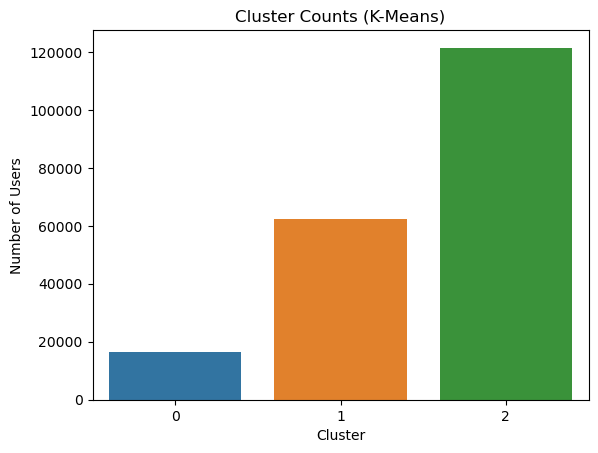


Fraud Distribution Across Clusters:
Is_Fraud       0    1
Cluster              
0          16336  237
1          61843  388
2         121314  132


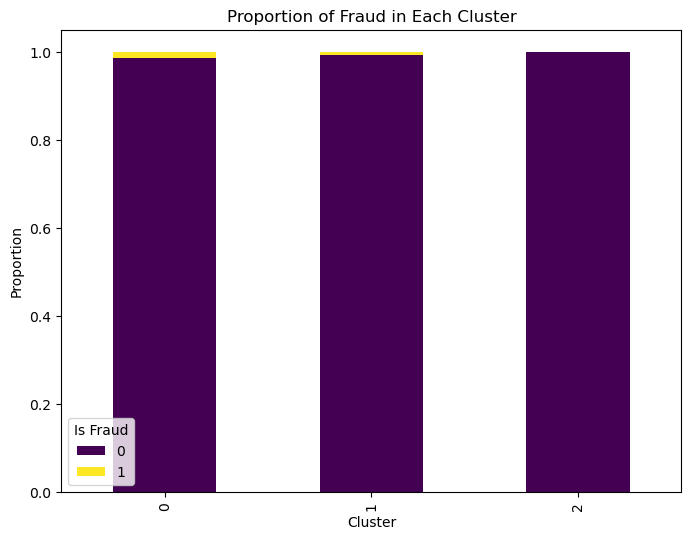

In [1]:
# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 2: Load Datasets
users = pd.read_csv(r"C:\Users\TTKT\Downloads\FDA Final\users.csv")           
transactions = pd.read_csv(r"C:\Users\TTKT\Downloads\FDA Final\transactions.csv")  
fraudsters = pd.read_csv(r"C:\Users\TTKT\Downloads\FDA Final\fraudsters.csv")  
print("data loaded")

# STEP 3: Feature Engineering (same as before)
fraud_ids = set(fraudsters['USER_ID'])

txn_grp = transactions.groupby('USER_ID')
user_features = txn_grp.agg(
    trans_count=('ID', 'count'),
    total_amount=('AMOUNT_GBP', 'sum'),
    avg_amount=('AMOUNT_GBP', 'mean'),
    failed_count=('STATE', lambda x: (x == 'FAILED').sum()),
    currency_count=('CURRENCY', pd.Series.nunique)
).reset_index()
user_features['fail_rate'] = user_features['failed_count'] / user_features['trans_count']

type_dummies = pd.get_dummies(transactions['TYPE'])
type_counts = transactions[['USER_ID']].join(type_dummies).groupby('USER_ID').sum().reset_index()

features = pd.merge(user_features, type_counts, on='USER_ID', how='left')
features = pd.merge(features, users, left_on='USER_ID', right_on='ID', how='left')
today = datetime(2025, 5, 15)
features['CREATED_DATE'] = pd.to_datetime(features['CREATED_DATE'], errors='coerce')
features['BIRTH_DATE'] = pd.to_datetime(features['BIRTH_DATE'], errors='coerce')
if features['CREATED_DATE'].isnull().any() or features['BIRTH_DATE'].isnull().any():
    print("Warning: Some dates failed to parse. Check the original data format.")
features['account_age_days'] = (today - features['CREATED_DATE']).dt.days
features['user_age'] = ((today - features['BIRTH_DATE']).dt.days / 365).astype(int)

features.drop(['CREATED_DATE', 'BIRTH_DATE', 'ID'], axis=1, inplace=True)
features = pd.get_dummies(features, columns=['COUNTRY'], prefix='Country')

print("feature engineering completed")

# Save fraud label separately to compare after clustering
features['is_fraud'] = features['USER_ID'].isin(fraud_ids).astype(int)
fraud_labels = features['is_fraud']
features.drop(['USER_ID', 'is_fraud'], axis=1, inplace=True)

# STEP 4: Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# STEP 5: K-Means Clustering
n_clusters = 3  # You can adjust this based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
features['cluster'] = clusters

# STEP 6: Evaluate Clustering
sil_score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

# Visualize cluster distribution
sns.countplot(x=clusters)
plt.title("Cluster Counts (K-Means)")
plt.xlabel("Cluster")
plt.ylabel("Number of Users")
plt.show()

# STEP 7: Compare Clusters with Fraud Labels
comparison_df = pd.DataFrame({'Cluster': clusters, 'Is_Fraud': fraud_labels})
fraud_cluster_counts = comparison_df.groupby(['Cluster', 'Is_Fraud']).size().unstack(fill_value=0)

print("\nFraud Distribution Across Clusters:")
print(fraud_cluster_counts)

# Optional: Visualize fraud proportions per cluster
fraud_cluster_counts.div(fraud_cluster_counts.sum(axis=1), axis=0).plot(
    kind='bar', stacked=True, figsize=(8, 6), colormap='viridis'
)
plt.title("Proportion of Fraud in Each Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title="Is Fraud")
plt.show()


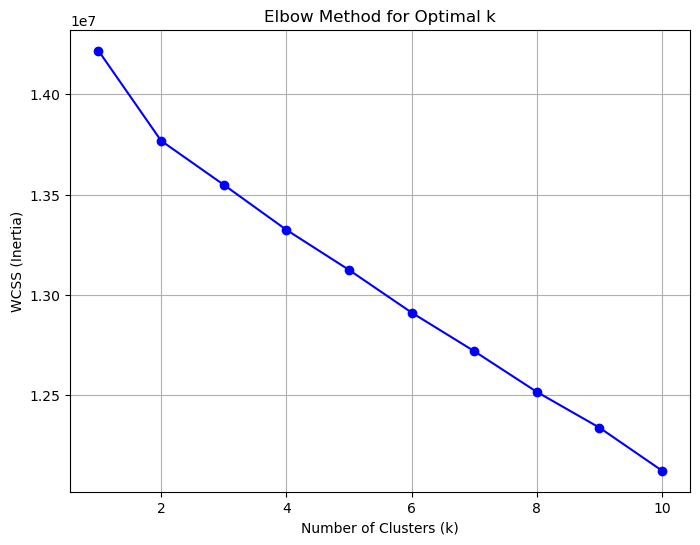

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Using scaled features from before
X = X_scaled

wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, 'bo-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()


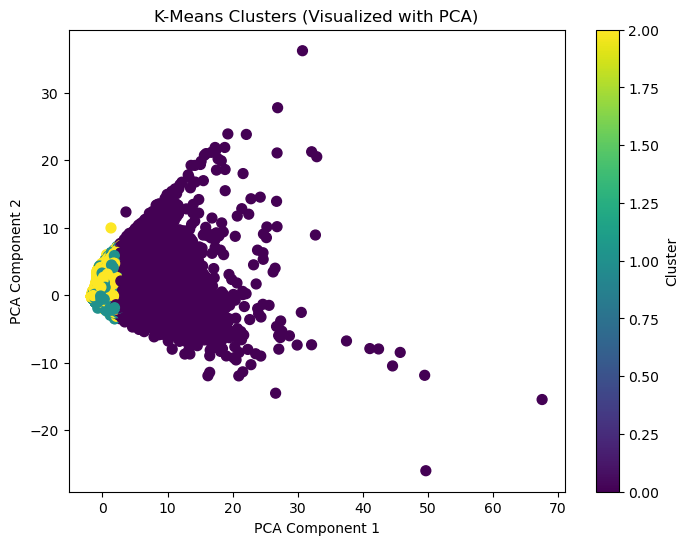

In [3]:
from sklearn.decomposition import PCA

# PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize with the current k (say, k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('K-Means Clusters (Visualized with PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
